# Strawberry Classification via mid-IR Spectra

## Introduction

Spectroscopy detects molecular vibration in a non-destructive manner by shining infrared light on a sample causing the molecular bonds to vibrate at specific frequencies as they absorb or transmit light energy. The more concentrated a specific type of molecule is, and its respective bonds, the higher the intensity of signal given from the vibration. This relationship between signal and concentration is known as Beer-Lambert’s law. It is because of these varying intensities at different frequencies, the presence of molecules can be detected and quantified using machine learning techniques.

Each of these different frequencies is another column or feature in the data set. And because gathering spectroscopy data over thousands of different samples can be unfeasible, typically these data sets are wide. Whenever a data set is wide, different techniques are necessary to make predictions. This is where partial least squares (PLS) comes in handy. 

PLS is dimensionality reduction technique used mostly in the field of chemical machine learning (chemometrics) due to the high dimensional nature of many chemical instruments and applications. It is a close cousin of Principal Component  Regression which takes all the different features (in this case wavelengths) and combines them into a user-defined number of features (known as principal components) based on variance. Once the number of features is smaller than number of rows (p < n), an ordinary least squares or logisitic regression can be performed. However, it bases the combination of features solely on the features. Where PLS has an advantage is that it decomposes both the features and the predicator variable(s) in order to maximize the relationship to the feature variable. This provides a possibly better set of new features geared towards helping to predict the response variable more accurately. 

After those features are obtained, PLS uses ordinary least squares to predict quantities. Partial Least Squares-Discriminant Analysis is a slightly tweaked method off of PLS in order to perform classifications. It performs the normal PLS analysis, but then uses the predicted continuous value and rounds it to either 0 or 1 for binary classifications. 

While PLS has been successfully used in chemometrics for over 3 decades, there are other more modern techniques now used in machine learning such as boosting techniques and decision tree classifiers. The question this paper attempts to answer is:

Would one of the more modern machine learning techniques such as boosting, random forest, or k-nearest neighbors provide better prediction accuracy than partial least squares-discriminant analysis?

### Data / Libraries

The data used is from the original spectra used by Holland, Kemsley, and Wilson<sup>2</sup>. It is a set of 983 samples of fruit puree. Using the 236 wavelengths from mid-infrared spectrscopy, can the classification models predict whether the fruit purees contain strawberry?

This particular set is not completely typical of spectroscopy data because n > p as it normally would be. However, this data set has already narrowed down the range into a specific region of spectroscopy known as the "fingerprint region." An area commonly used for it's ability to identify certain compounds by their "fingerprint." Even if n > p in this case, the number of features still remains quite high and requires a decent amount of feature reduction in order to run some of the less flexible models such as logistic regression. 

In [120]:
import pandas as pd
import numpy as np
import scipy.io as spy
import matplotlib.pyplot as plt
import re
import seaborn as sns



from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from rotation_forest import RotationForestClassifier
from sklearn.cross_decomposition import PLSRegression
import xgboost as xgb


df = pd.read_csv('MIR_Fruit_purees.csv')

In [121]:
df.shape

(983, 236)

## Data Cleaning

Fortunately, the data for this set is relatively clean. A `countplot` will help see how well balanced the response variable is for this given data set. It shows that this is a somewhat imbalanced data set. Any result from the model will likely favor the negative results, or not strawberry. Imbalanced data tends to still have a fine result for accuracy, but the recall or precision can suffer as a result. In this case, recall due to being more 0 values than 1 (after OneHot encoding). Something to keep in mind going forward.

The only issue was the target variable being a string instead of an integer. All classification models used for this project need the response as numeric values in order to function properly. This is easily remedied using OneHot encoding through the `pd.get_dummies` function.

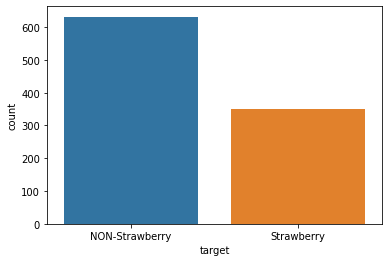

In [122]:
sns.countplot(x=df['target']);

In [123]:
df = pd.get_dummies(df, drop_first=True)

## Exploratory Data Analysis

The `df.describe()` function in pandas allows us to quickly observe the univariate statistics of each wavelength including mean, standard deviation, and various percentiles.

In [124]:
df.describe(percentiles=[0.05, 0.95])

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,target_Strawberry
count,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,...,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,9.830000e+02,983.00000
mean,0.002450,0.002465,0.002495,0.002604,0.002811,0.003044,0.003176,0.003174,0.003096,0.002994,...,0.000218,0.000139,0.000092,0.000062,0.000041,0.000029,0.000019,0.000009,8.365281e-06,0.35707
std,0.000342,0.000351,0.000383,0.000428,0.000495,0.000596,0.000710,0.000792,0.000790,0.000718,...,0.000159,0.000122,0.000100,0.000078,0.000059,0.000039,0.000026,0.000011,1.130128e-05,0.47938
min,0.001391,0.001389,0.001371,0.001472,0.001585,0.001667,0.001738,0.001754,0.001791,0.001836,...,-0.000073,-0.000061,-0.000050,-0.000049,-0.000084,-0.000023,-0.000055,-0.000014,-1.370000e-05,0.00000
5%,0.001873,0.001874,0.001865,0.001915,0.002046,0.002199,0.002246,0.002197,0.002153,0.002131,...,0.000014,0.000001,-0.000011,-0.000011,-0.000013,-0.000002,-0.000007,-0.000001,-6.652000e-07,0.00000
50%,0.002449,0.002469,0.002494,0.002592,0.002779,0.002969,0.003054,0.003025,0.002948,0.002856,...,0.000192,0.000116,0.000074,0.000048,0.000031,0.000022,0.000014,0.000008,6.920000e-06,0.00000
95%,0.002979,0.002990,0.003071,0.003290,0.003634,0.004037,0.004482,0.004718,0.004669,0.004414,...,0.000508,0.000329,0.000226,0.000155,0.000106,0.000067,0.000058,0.000021,1.988000e-05,1.00000
max,0.003317,0.003450,0.003648,0.003943,0.004506,0.005230,0.005935,0.006418,0.006391,0.005979,...,0.001495,0.001423,0.001319,0.001122,0.000889,0.000644,0.000380,0.000187,1.871680e-04,1.00000


Now, lets plot a few different ways to look at the data. First, a plot of all of the data together. Then two comparison plots of each classification by mean and standard deviation to visualize the differences between the two labels.

Before any plots can be made, it is important to drop the target column from each data frame. When comparing the strawberry vs. not strawberry, the target column does not need to be retained. However, for the complete data set used for predictions, I'll keep the target as my `y` variable to be used later in the modeling.

In [125]:
SPEC_RANGE = np.linspace(899, 1802.6, 235)

In [126]:
X = df.drop('target_Strawberry', axis=1)
y = df['target_Strawberry']
X = (1 - X) * 100

In [127]:
strawberry = df.loc[df['target_Strawberry'] == 0]
strawberry = strawberry.drop('target_Strawberry', axis=1)
strawberry = (1 - strawberry) * 100
strawberry_mean = np.mean(strawberry)
strawberry_std = np.std(strawberry)

not_strawberry = df.loc[df['target_Strawberry'] == 1]
not_strawberry = not_strawberry.drop('target_Strawberry', axis=1)
not_strawberry = (1 - not_strawberry) * 100
not_strawberry_mean = np.mean(not_strawberry)
not_strawberry_std = np.std(not_strawberry)

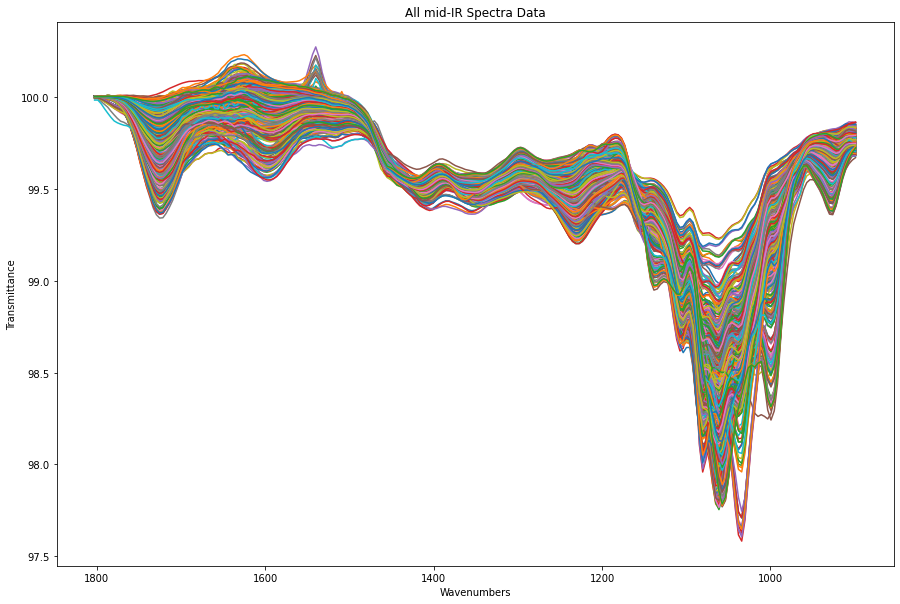

In [128]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(SPEC_RANGE, X.T.values);
ax.set_xlabel('Wavenumbers');
ax.set_ylabel('Transmittance');
ax.set_title('All mid-IR Spectra Data');
ax.invert_xaxis()
fig.savefig('All spectra.png')

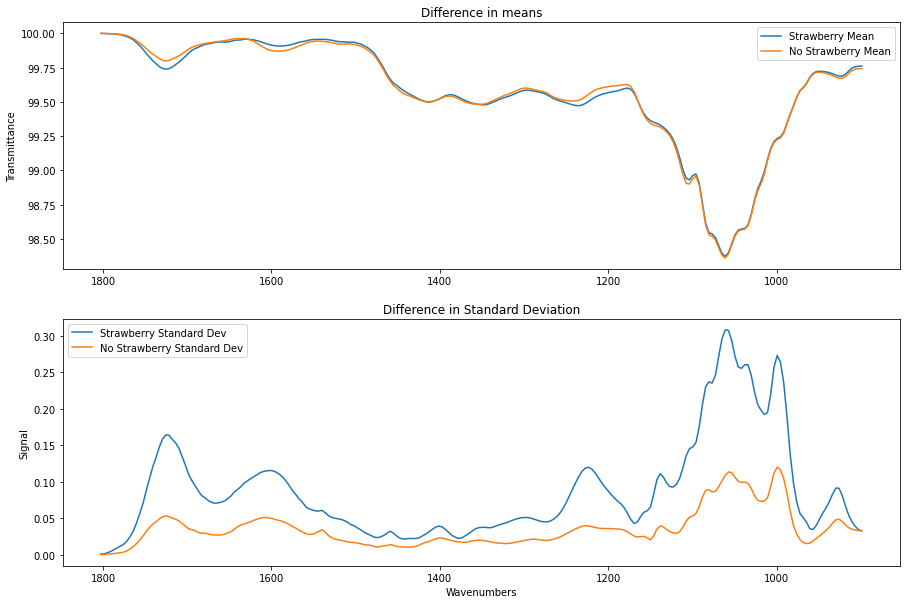

In [129]:
fig, ax = plt.subplots(2,1, sharey=False, figsize=(15,10))
ax[0].plot(SPEC_RANGE, strawberry_mean, label='Strawberry Mean')
ax[0].plot(SPEC_RANGE, not_strawberry_mean, label='No Strawberry Mean')
ax[0].set_ylabel('Transmittance')
ax[0].set_title('Difference in means')
ax[0].legend()
ax[0].invert_xaxis()

ax[1].plot(SPEC_RANGE, strawberry_std, label='Strawberry Standard Dev')
ax[1].plot(SPEC_RANGE, not_strawberry_std, label='No Strawberry Standard Dev')
ax[1].set_ylabel('Signal');
ax[1].set_xlabel('Wavenumbers');
ax[1].set_title('Difference in Standard Deviation');
ax[1].legend()
ax[1].invert_xaxis()

From observing the differences plots between the two classes, there is not much of a difference is the means &mdash; only small little differences are readily apparent. The standard deviations of the two data sets show a different picture. The responses containing strawberry shows a wide variance, likely due to different concentrations of strawberry in the samples. This variance is hopefully something the different models will be able to extract for the future classifications. 

## Modeling

With the exploratory stage complete, it is time to start modeling the data. The 'modern' models that are going to be used will be K-nearest neighbors, random forest, rotation forest, and boosting in the form of XGBoost. Boosting, rotation forest, and random forest use decision trees to make their predictions. 

While random forest uses a more randomized approach to check different feature columns (in this case wavenumbers) and values, boosting learns from each iteration to try and improve upon the previous iteration. Rotation forest is similar to random forest but performs a transformation before creating the decision trees and has been found to be especially helpful for high dimensionality data sets. K-nearest neighbors (KNN) is a classification technique used to predict an unknown value by looking at the labels of points nearest it (according the Euclidean distance) with the K value being the user-defined number of neighbors. The highest 'vote' total from the labeled neighbors determines what the unknown prediction will be.

These 'modern' techniques are contrasted with the more commonly used technique of partial least squares-discriminant analysis (PLS-DA). For classifications with spectra modeling, this has been the go-to for decades. 

It is important, especially for KNN, for the data to be normalized. This is quickly performed using StandardScaler from sklearn. Because of the imbalance of the data, more than double of the not-strawberry samples vs. strawberry, it might be wise to run an imbalance technique known as Synthetic Minority Oversampling Technique (SMOTE).

Hyper parameter tuning is crucial for each of these and will help to fine tune the best parameters for the models.

In [130]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

Contrasting the before SMOTE and after SMOTE, the results on all models were improved. Balancing the data set helped with the accuracy and recall by > 1%. 

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [132]:
rotate = RotationForestClassifier(n_estimators=100, bootstrap=True, max_features=0.05, n_jobs=4)
rotate.fit(X_train_scaled,y_train);

y_pred_rotate = rotate.predict(X_test_scaled)

class_report_rotate = classification_report(y_test, y_pred_rotate)
print(class_report_rotate)

cm_rotate = confusion_matrix(y_test, y_pred_rotate)
print(f'Confusion Table: \n{cm_rotate}\n')                             

acc_score_rotate = accuracy_score(y_test, y_pred_rotate)
print(f'Accuracy score {100 * acc_score_rotate:.2f}%')

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       203
           1       0.97      0.99      0.98       177

    accuracy                           0.98       380
   macro avg       0.98      0.98      0.98       380
weighted avg       0.98      0.98      0.98       380

Confusion Table: 
[[197   6]
 [  1 176]]

Accuracy score 98.16%


In [133]:
rf = RandomForestClassifier(n_estimators=400, max_features=0.05)
rf.fit(X_train_scaled,y_train);

y_pred_rf = rf.predict(X_test_scaled)

class_report_rf = classification_report(y_test, y_pred_rf)
print(class_report_rf)

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf

acc_score_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy score {100 * acc_score_rf:.2f}%')

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       203
           1       0.97      0.99      0.98       177

    accuracy                           0.98       380
   macro avg       0.98      0.98      0.98       380
weighted avg       0.98      0.98      0.98       380

Accuracy score 98.16%


In [134]:
boost = xgb.XGBClassifier(objective='binary:logistic', eval_metric = 'auc', seed=42)

model_boost = boost.fit(X_train_scaled, y_train)

y_pred_boost = boost.predict(X_test_scaled)

acc_boost = classification_report(y_test, y_pred_boost)
print(acc_boost)

cm_boost = confusion_matrix(y_test, y_pred_boost)
cm_boost

acc_score_boost = accuracy_score(y_test, y_pred_boost)
print(f'Accuracy score {100 * acc_score_boost:.2f}%')

C:\Users\kylel\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       203
           1       0.98      0.97      0.97       177

    accuracy                           0.98       380
   macro avg       0.98      0.98      0.98       380
weighted avg       0.98      0.98      0.98       380

Accuracy score 97.63%


In [135]:
knn = KNeighborsClassifier(n_neighbors=4)
model_knn = knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

acc_knn = classification_report(y_test, y_pred_knn)
print(acc_knn)

cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn

acc_score_knn = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy score {100 * acc_score_knn:.2f}%')

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       203
           1       0.95      0.99      0.97       177

    accuracy                           0.97       380
   macro avg       0.97      0.97      0.97       380
weighted avg       0.97      0.97      0.97       380

Accuracy score 97.11%


In [136]:
pls = PLSRegression(n_components=17)
model_pls = pls.fit(X_train_scaled, y_train)

y_pred_pls = pls.predict(X_test_scaled).round()

acc_pls = classification_report(y_test, y_pred_pls)
print(acc_pls)

cm_pls = confusion_matrix(y_test, y_pred_pls)
cm_pls

acc_score_pls = accuracy_score(y_test, y_pred_pls)
print(f'Accuracy score {100 * acc_score_pls:.2f}%')

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97       203
         1.0       0.95      0.99      0.97       177
         2.0       0.00      0.00      0.00         0

    accuracy                           0.97       380
   macro avg       0.65      0.65      0.65       380
weighted avg       0.97      0.97      0.97       380

Accuracy score 97.11%


C:\Users\kylel\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [138]:
final_results = pd.DataFrame({'Model': ['PLS-DA', 'Rotation Forest', 'Random Forest', 
                                        'KNN', 'XGBoost'], 
                              'Accuracy (%)': [acc_score_pls*100, acc_score_rotate*100, acc_score_rf*100, 
                                           acc_score_knn*100, acc_score_boost*100]}).round(decimals=2)
final_results

,Model,Accuracy (%)
0,PLS-DA,97.11
1,Rotation Forest,98.16
2,Random Forest,98.16
3,KNN,97.11
4,XGBoost,97.63


## Conclusion
While the PLS-DA performed surprisingly well once tuned to the correct number of latent variables, it did not outperform any of the other models, including KNN. Rotation Forest, Random Forest, and XGBoost outperformed all other models quite comfortably with XGBoost performing best overall with > 98% recall and precision on both classes as well. While PLS-DA has been the mainstay for many years, and still performs admirably, it does not seem to have the same sort of prediction power as some of the other 'modern' machine learning techniques in this instance.    


#### References
1. Paper =  https://onlinelibrary.wiley.com/doi/10.1002/(SICI)1097-0010(199802)76:2%3C263::AID-JSFA943%3E3.0.CO;2-F
2. Data = https://csr.quadram.ac.uk/example-datasets-for-download/